(2522362, 79)
 Label
Normal     2096484
Anormal     425877
Name: count, dtype: int64
 Label
Normal     100000
Anormal    100000
Name: count, dtype: int64
 Label
Anormal    99964
Normal     99927
Name: count, dtype: int64
(139923, 78)
(59968, 78)
Original dataset shape Counter({'Normal': 70116, 'Anormal': 69807})
Resampled dataset shape Counter({'Anormal': 70116, 'Normal': 70116})


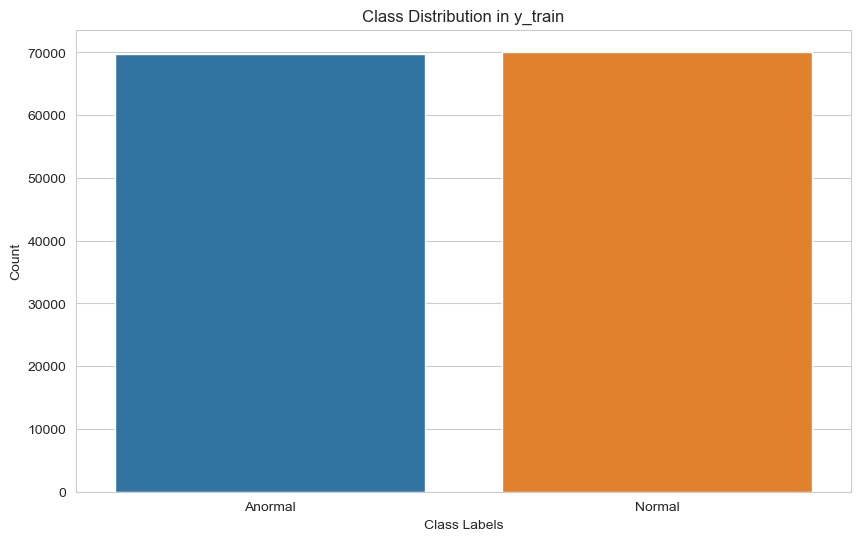

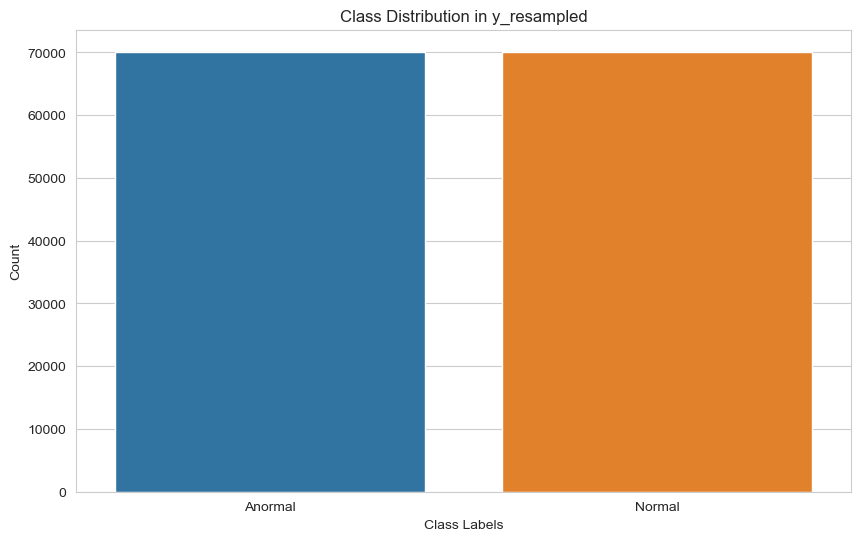

(98162, 78)
(42070, 78)
Selected Features:
Index([' Destination Port', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', 'Bwd Packet Length Max',
       ' Bwd Packet Length Mean', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', ' Average Packet Size',
       ' Avg Bwd Segment Size', ' Subflow Fwd Bytes', ' Subflow Bwd Bytes',
       'Init_Win_bytes_forward'],
      dtype='object')
Model: SVM
Accuracy: 92.3604%
Training time: 429.40 seconds
Testing Time: 106.5635 seconds
Classification Report:
               precision    recall  f1-score   support

     Anormal       0.89      0.97      0.93     21015
      Normal       0.97      0.88      0.92     21055

    accuracy                           0.92     42070
   macro avg       0.93      0.92      0.92     42070
weighted avg       0.93      0.92      0.92     42070



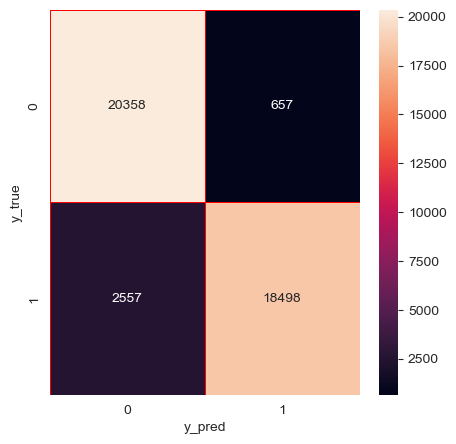

---------------


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
import time
# Load the CIC-IDS2017 dataset (replace 'dataset.csv' with the actual file path)
data = pd.read_csv('dataset/Normal_Anormal_dataset.csv')
print (data.shape)
count=data[' Label'].value_counts()
print(count)
def perform_random_sampling(df, label_column):
    unique_labels = df[label_column].unique()

    under_sampled_df = pd.DataFrame()

    for label in unique_labels:
        label_data = df[df[label_column] == label]
        num_samples_label = len(label_data)

        if num_samples_label > 400000:
            under_sampled_label = label_data.sample(n=100000, random_state=42)
            under_sampled_df = pd.concat([under_sampled_df, under_sampled_label])
        else:
            under_sampled_df = pd.concat([under_sampled_df, label_data])
    return under_sampled_df

under_sampled_data = perform_random_sampling(data, ' Label')
Sampled = under_sampled_data[' Label'].value_counts()
print(Sampled)
# Assuming 'df' is your DataFrame
# Remove NaN and Inf values
df = under_sampled_data.replace([np.inf, -np.inf], np.nan).dropna()

# Remove null values
df = df.dropna()
count_res=df[' Label'].value_counts()
print(count_res)
X = df.drop(' Label', axis=1)
y = df[' Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

print('Original dataset shape %s' % Counter(y_train))
# Perform borderline SMOTE over-sampling
smote = BorderlineSMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled))

original_counts = Counter(y_train)
class_labels = list(original_counts.keys())
class_counts = list(original_counts.values())
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")  # Optional, set the style
sns.barplot(x=class_labels, y=class_counts)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Class Distribution in y_train')
plt.show()
resampled_counts=Counter(y_resampled)
class_labels = list(original_counts.keys())
class_counts = list(resampled_counts.values())

# Create a bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")  # Optional, set the style
sns.barplot(x=class_labels, y=class_counts)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Class Distribution in y_resampled')

plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

# Feature selection using mutual information gain ratio
selector = SelectKBest(mutual_info_classif, k=14)
X_train_selected = selector.fit_transform(X_train, y_train)
# Get indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features from the original dataframe (assuming X is a DataFrame)
selected_features = X.columns[selected_indices]

# Print the names of the selected features
print("Selected Features:")
print(selected_features)
# Scaling features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(selector.transform(X_test))

# Deleting NaN/inf values
imputer = SimpleImputer(strategy='mean')
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

# Training and evaluating models
models = {
    'SVM': SVC()
}


for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled,y_train )
    training_time = time.time() - start_time
    # Testing time calculation
    start_test_time = time.time()
    y_pred = model.predict(X_test_scaled)
    end_test_time = time.time()
    test_time = end_test_time - start_test_time
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_percentage = accuracy * 100
    report = classification_report(y_test, y_pred)
    
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_percentage:.4f}%")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Testing Time: {test_time:.4f} seconds")
    print("Classification Report:\n", report)
    y_true=y_test
    cm=confusion_matrix(y_true,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    print("---------------")


In [9]:
# to create a csv file 4 features
input_file = 'dataset/Normal_Anormal_dataset.csv'
output_file = 'IDS_14_dataset.csv'
columns_to_select = [' Destination Port', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', 'Bwd Packet Length Max',
       ' Bwd Packet Length Mean', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', ' Average Packet Size',
       ' Avg Bwd Segment Size', ' Subflow Fwd Bytes', ' Subflow Bwd Bytes',
       'Init_Win_bytes_forward',' Label']

data = pd.read_csv(input_file)
selected_columns = data[columns_to_select]
selected_columns.to_csv(output_file, index=False)

# Making a Predictive System


1	49188	12	0	0	0.0	6	6.0	0.0	0.0	9.0	0.0	12	0	329	Normal



	 Destination Port	Total Length of Fwd Packets	 Total Length of Bwd Packets	Bwd Packet Length Max	 Bwd Packet Length Mean	 Max Packet Length	 Packet Length Mean	 Packet Length Std	 Packet Length Variance	 Average Packet Size	 Avg Bwd Segment Size	 Subflow Fwd Bytes	 Subflow Bwd Bytes	Init_Win_bytes_forward	 Label
2183888	6001	2	6	6	6.0	6	3.333333333	2.309401077	5.333333333	5.0	6.0	2	6	1024	Anormal

Index([' Destination Port', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', 'Bwd Packet Length Max',
       ' Bwd Packet Length Mean', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', ' Average Packet Size',
       ' Avg Bwd Segment Size', ' Subflow Fwd Bytes', ' Subflow Bwd Bytes',
       'Init_Win_bytes_forward', ' Label'],
      dtype='object')
Predictions for new data:
['Normal' 'Normal' 'Anormal' 'Normal' 'Anormal' 'Normal' 'Anormal'
 'Normal' 'Normal' 'Normal' 'Anormal' 'Normal' 'Normal' 'Anormal'
 'Anormal' 'Normal' 'Normal' 'Normal' 'Anormal' 'Normal' 'Normal' 'Normal'
 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal'
 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Anormal' 'Normal' 'Normal'
 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal'
 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'Normal'
 'Normal' 'Normal' 'Normal' 'Normal' 'Normal' 'An

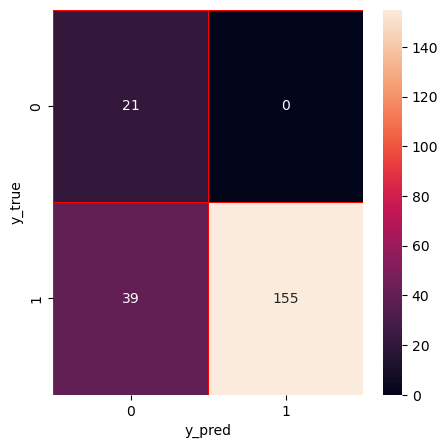

---------------


In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,confusion_matrix

# loading the saved model
loaded_model = pickle.load(open('_14_model.sav', 'rb'))

# Load the new dataset
new_data = pd.read_csv('test.csv')  # Update the file path

# Check the column names in the new dataset
print(new_data.columns)

# Preprocess the new dataset
# Assuming you've already defined the 'selector', 'scaler', and 'imputer' objects
new_data_clean = new_data.replace([np.inf, -np.inf], np.nan).dropna()
new_data_clean = new_data_clean.dropna()

# Replace 'Label' below with the correct column name for your target variable in the new dataset
X_new = new_data_clean.drop(' Label', axis=1)  # Adjust according to your columns
y_new = new_data_clean[' Label']  # Adjust according to your column name

# Initialize scaler and imputer
scaler = MinMaxScaler()  # You can also use StandardScaler or any other scaler you used in training
imputer = SimpleImputer(strategy='mean')  # Or any other imputer strategy you used in training

# Feature selection for the new data
selector = SelectKBest(mutual_info_classif, k=14)
X_train_selected = selector.fit_transform(X_new, y_new)
X_new_selected = selector.transform(X_new)

# Fit the scaler on the selected features from the training data
scaler.fit(X_train_selected)

# Transform the new data using the fitted scaler
X_new_selected_scaled = scaler.transform(X_new_selected)

# Use the previously fitted imputer to handle NaN/inf values
X_new_selected_scaled_imputed = imputer.fit_transform(X_new_selected_scaled)

# Prediction using the trained model
y_pred_new = loaded_model.predict(X_new_selected_scaled_imputed)

# Output the prediction for the new data
print("Predictions for new data:")
print(y_pred_new)

accuracy = accuracy_score(y_new, y_pred_new)
accuracy_percentage = accuracy * 100
print(f"Accuracy: {accuracy_percentage:.4f}%")
cm=confusion_matrix(y_new, y_pred_new)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()
print("---------------")


In [12]:
input_data = (6001,2,6,6,6.0,6,3.333333333,2.309401077,5.333333333,5.0,6.0,2,6,1024)
# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = loaded_model.predict(input_data_reshaped)
print(prediction)

if (prediction[0] == 'Normal'):
    
  print('Normal')
else:
  print('Anormal')

['Anormal']
Anormal
